In [1]:
#PrimeTrade AI Project - Historical Trader Data

In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import shap

In [3]:
df = pd.read_csv("/kaggle/input/historical-trader-data/historical_data.csv")
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


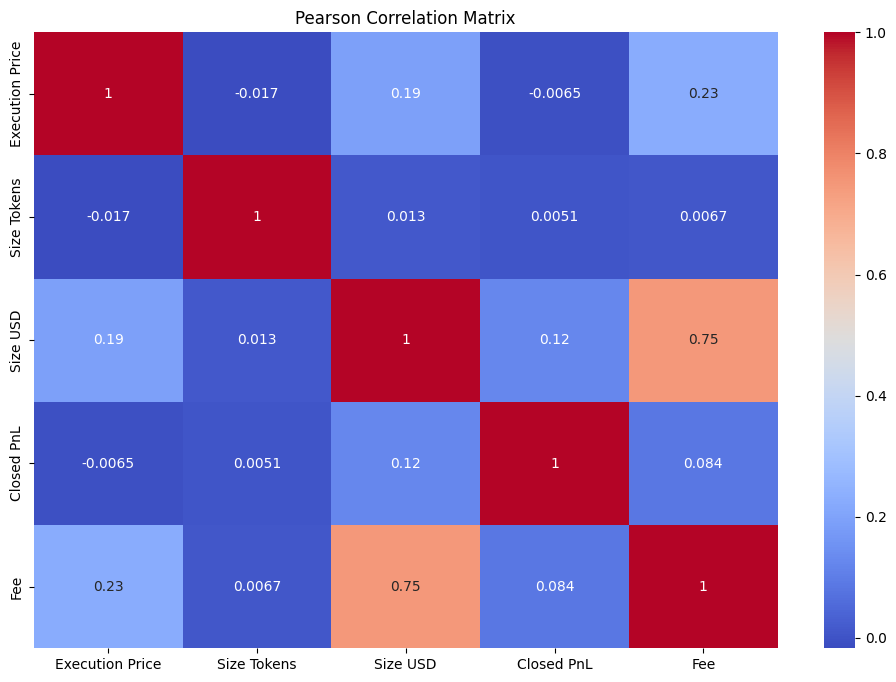

In [16]:
#Data Preprocessing

missing = df.isnull().sum()
print(missing)

df = df.drop_duplicates()

df['Timestamp'] = pd.to_datetime(
    df['Timestamp'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

df['Timestamp IST'] = pd.to_datetime(
    df['Timestamp IST'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

df['date'] = df['Timestamp'].dt.date

num_cols = ['Execution Price', 'Size Tokens', 'Size USD','Closed PnL', 'Fee']

cat_cols = ['Account', 'Coin', 'Side', 'Direction', 'Crossed']


#Imputing
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

#Encode
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#Scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

#Correlation Coefficient
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(method='pearson'),
            annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Matrix")
plt.show()

#Features to be dropped
df.drop(columns=[
    'Transaction Hash', 'Order ID', 'Trade ID'
], inplace=True)

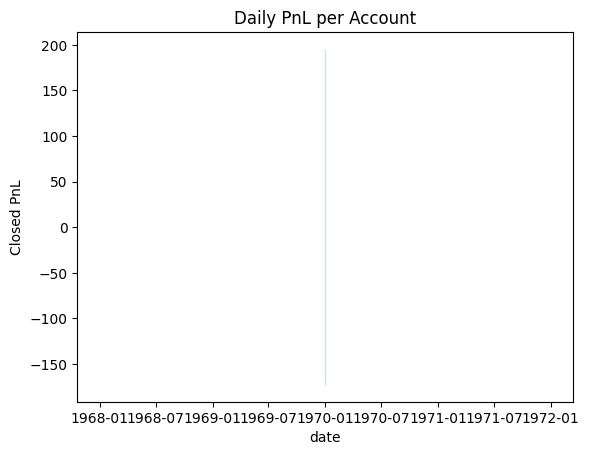

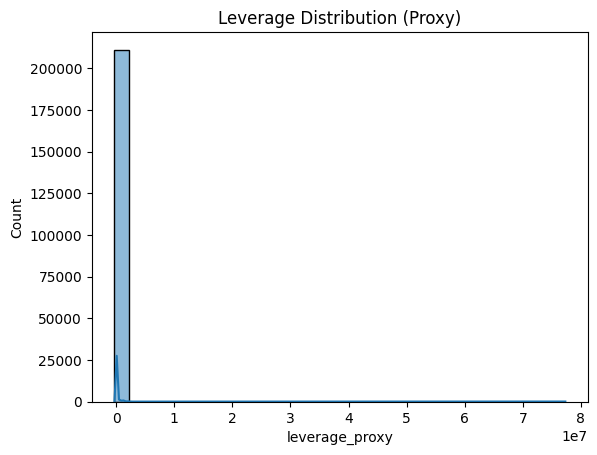

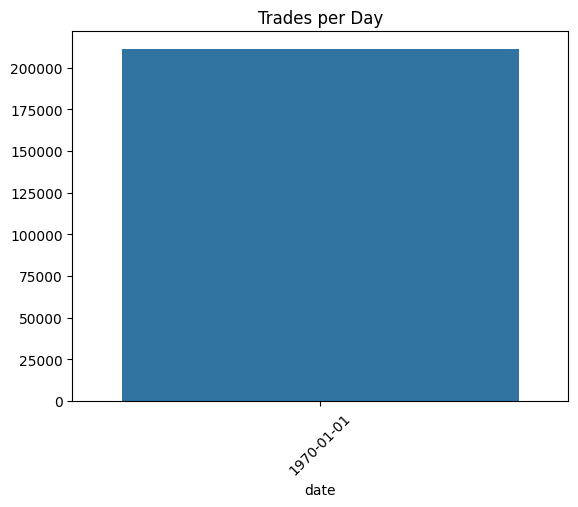

Direction
6     0.236218
2     0.230457
7     0.188146
3     0.170497
8     0.094222
1     0.079139
11    0.000672
10    0.000331
5     0.000270
0     0.000038
4     0.000005
9     0.000005
Name: proportion, dtype: float64


In [17]:
# Trading Metrics

#dailt P&L
daily_pnl = df.groupby(['date', 'Account'])['Closed PnL'].sum().reset_index()
sns.lineplot(data=daily_pnl, x='date', y='Closed PnL')
plt.title("Daily PnL per Account")
plt.show()

# Avg. Trade volume
trade_stats = df.groupby('Account').agg(
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_trade_size_usd=('Size USD', 'mean'),
    total_trades=('Closed PnL', 'count')
).reset_index()

trade_stats.head()

#Leverage dist.
df['leverage_proxy'] = df['Size USD'] / (df['Start Position'] + 1e-6)

sns.histplot(df['leverage_proxy'], bins=30, kde=True)
plt.title("Leverage Distribution (Proxy)")
plt.show()

#Trades per day
trades_per_day = df.groupby('date').size()

sns.barplot(x=trades_per_day.index, y=trades_per_day.values)
plt.xticks(rotation=45)
plt.title("Trades per Day")
plt.show()

#Long term vs Short term
long_short_ratio = df['Direction'].value_counts(normalize=True)
print(long_short_ratio)

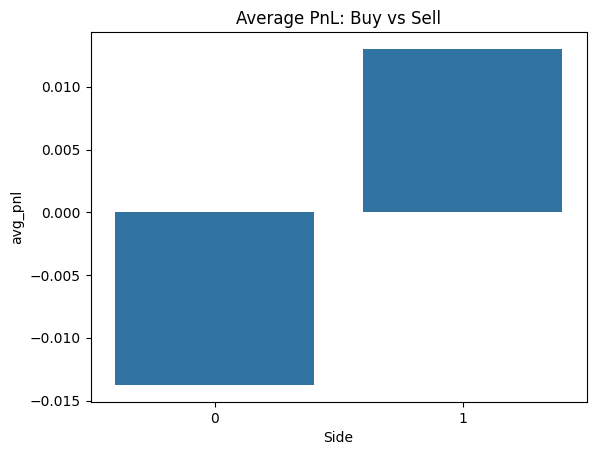

In [18]:
#Buy vs Sell
side_perf = df.groupby('Side').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count')
)

side_perf

sns.barplot(x=side_perf.index, y=side_perf['avg_pnl'])
plt.title("Average PnL: Buy vs Sell")
plt.show()

In [19]:
#Behavioral Analysis
behavioral_impact = df.groupby(['Direction', 'Crossed']).agg(
    avg_pnl=('Closed PnL', 'mean'),
    trade_count=('Closed PnL', 'count')
).reset_index()

behavioral_impact

,Direction,Crossed,avg_pnl,trade_count
0,0,1,7.763651,8
1,1,0,-0.053036,5017
2,1,1,-0.053036,11699
3,2,0,0.007278,19604
4,2,1,0.041864,29074
5,3,0,0.186590,13346
6,3,1,-0.016066,22667
7,4,0,-13.927526,1
8,5,0,0.099817,23
9,5,1,-0.092716,34


In [22]:
#Behavioral Profile
trader_features = df.groupby('Account').agg(
    avg_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    avg_trade_size=('Size USD', 'mean'),
    trade_frequency=('Closed PnL', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean())
).fillna(0)

trader_features['leverage_group'] = np.where(
    trader_features['avg_trade_size'] > trader_features['avg_trade_size'].median(),
    'High Leverage', 'Low Leverage'
)

trader_features['frequency_group'] = np.where(
    trader_features['trade_frequency'] > trader_features['trade_frequency'].median(),
    'Frequent', 'Infrequent'
)

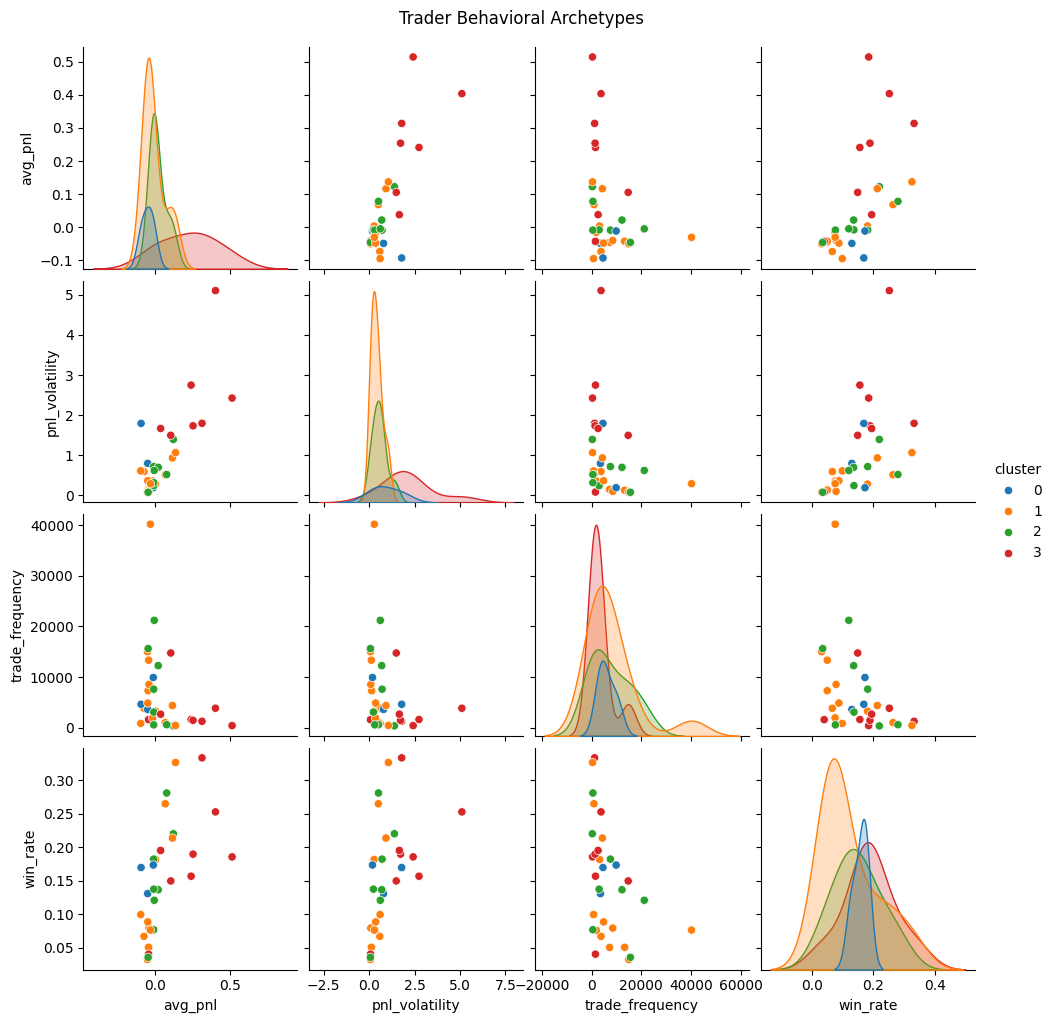

,avg_pnl,avg_volatility,avg_win_rate,avg_trade_freq,count
cluster,,,,,
0,-0.050891,0.925043,0.157820,6027.666667,3
1,-0.008814,0.417054,0.123496,8050.153846,13
2,0.018287,0.570548,0.148677,7637.250000,8
3,0.228084,2.130222,0.187748,3423.875000,8


In [26]:
#Behavioral Archetypes (Clustering)
from sklearn.cluster import KMeans

trader_features = df.groupby('Account').agg(
    avg_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    avg_trade_size=('Size USD', 'mean'),
    trade_frequency=('Closed PnL', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_fee=('Fee', 'mean'),
    avg_execution_price=('Execution Price', 'mean'),
    dominant_side=('Side', lambda x: x.mode()[0]),
    dominant_direction=('Direction', lambda x: x.mode()[0]),
    dominant_coin=('Coin', lambda x: x.mode()[0])
).fillna(0)

num_features = [
    'avg_pnl',
    'pnl_volatility',
    'avg_trade_size',
    'trade_frequency',
    'win_rate',
    'avg_fee',
    'avg_execution_price'
]

cat_features = [
    'dominant_side',
    'dominant_direction',
    'dominant_coin'
]

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
)

encoded_cat = ohe.fit_transform(trader_features[cat_features])

encoded_cat_df = pd.DataFrame(
    encoded_cat,
    columns=ohe.get_feature_names_out(cat_features),
    index=trader_features.index
)

final_features = pd.concat(
    [trader_features[num_features], encoded_cat_df],
    axis=1
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_features)

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

trader_features['cluster'] = kmeans.fit_predict(X_scaled)

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    trader_features.reset_index(),
    hue='cluster',
    vars=[
        'avg_pnl',
        'pnl_volatility',
        'trade_frequency',
        'win_rate'
    ],
    palette='tab10'
)
plt.suptitle("Trader Behavioral Archetypes", y=1.02)
plt.show()

cluster_summary = trader_features.groupby('cluster').agg(
    avg_pnl=('avg_pnl', 'mean'),
    avg_volatility=('pnl_volatility', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_freq=('trade_frequency', 'mean'),
    count=('avg_pnl', 'count')
)

cluster_summary

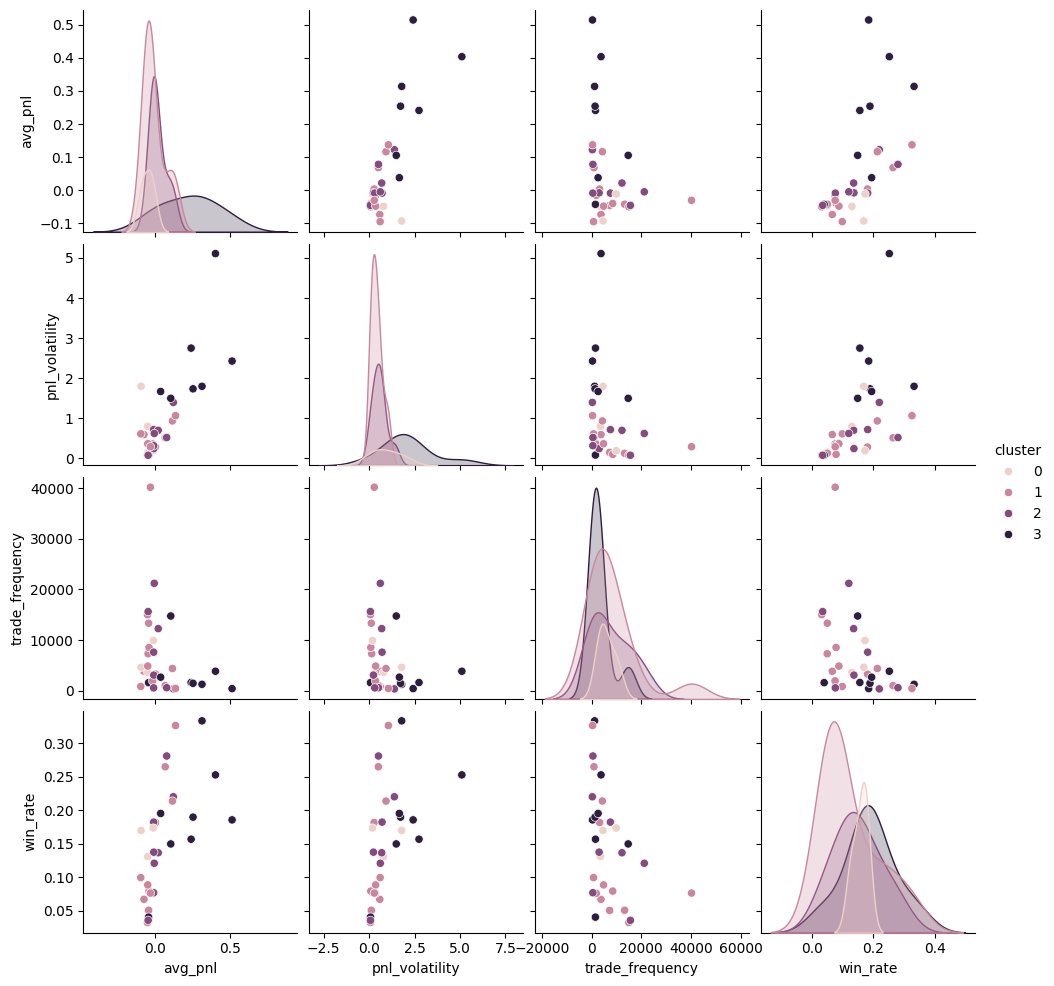

In [27]:
sns.pairplot(trader_features.reset_index(),
             hue='cluster',
             vars=['avg_pnl','pnl_volatility','trade_frequency','win_rate'])
plt.show()


In [ ]:
# XGBOOST REGRESSOR FOR FORECASTING
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TARGET = 'Closed PnL'

drop_cols = [
    'Closed PnL',
    'Transaction Hash',
    'Order ID',
    'Trade ID',
    'Timestamp',
    'Timestamp IST',
    'date'
]

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df[TARGET]

if X.shape[0] < 20:
    raise ValueError(
        f"Dataset too small for ML. "
        f"Need ≥20 rows, got {X.shape[0]}"
    )

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual PnL")
plt.ylabel("Predicted PnL")
plt.title("XGBoost Regression: Actual vs Predicted PnL")
plt.grid(True)
plt.show()


RMSE: 1.0304
MAE : 0.0683
R²  : 0.3772


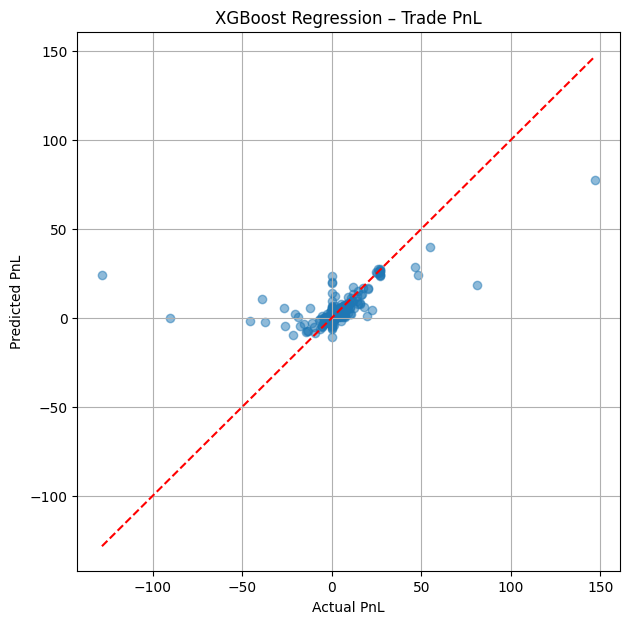

In [38]:
# ======================================
# FULL XGBOOST REGRESSION PIPELINE
# ======================================

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------------------
# 1. TARGET COLUMN
# --------------------------------------

TARGET = 'Closed PnL'

# --------------------------------------
# 2. DROP NON-PREDICTIVE IDENTIFIERS
# --------------------------------------

df_model = df.drop(
    columns=['Transaction Hash', 'Order ID', 'Trade ID'],
    errors='ignore'
)

# --------------------------------------
# 3. TIMESTAMP HANDLING (SAFE)
# --------------------------------------

df_model['Timestamp IST'] = pd.to_datetime(
    df_model['Timestamp IST'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

# Extract numeric time features
df_model['hour'] = df_model['Timestamp IST'].dt.hour
df_model['day_of_week'] = df_model['Timestamp IST'].dt.dayofweek

# Drop raw timestamps
df_model = df_model.drop(columns=['Timestamp', 'Timestamp IST'], errors='ignore')

# --------------------------------------
# 4. DEFINE FEATURE GROUPS
# --------------------------------------

categorical_cols = [
    'Account',
    'Coin',
    'Side',
    'Direction',
    'Crossed'
]

numerical_cols = [
    'Execution Price',
    'Size Tokens',
    'Size USD',
    'Start Position',
    'Fee',
    'hour',
    'day_of_week'
]

# --------------------------------------
# 5. ONE-HOT ENCODING (SKLEARN ≥1.2 SAFE)
# --------------------------------------

ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore'
)

encoded_cat = ohe.fit_transform(df_model[categorical_cols])

encoded_cat_df = pd.DataFrame(
    encoded_cat,
    columns=ohe.get_feature_names_out(categorical_cols),
    index=df_model.index
)

# --------------------------------------
# 6. FINAL FEATURE MATRIX
# --------------------------------------

X = pd.concat(
    [
        df_model[numerical_cols],
        encoded_cat_df
    ],
    axis=1
)

y = df_model[TARGET]

# --------------------------------------
# 7. HARD NUMERIC SANITIZATION (CRITICAL)
# --------------------------------------

# Force every column to numeric
X = X.apply(pd.to_numeric, errors='raise')

# Final safety check
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, \
    "Non-numeric columns still present!"

# --------------------------------------
# 8. TRAIN / TEST SPLIT
# --------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

# --------------------------------------
# 9. XGBOOST REGRESSOR
# --------------------------------------

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# --------------------------------------
# 10. TRAIN MODEL
# --------------------------------------

xgb_model.fit(X_train, y_train)

# --------------------------------------
# 11. PREDICTIONS
# --------------------------------------

y_pred = xgb_model.predict(X_test)

# --------------------------------------
# 12. METRICS
# --------------------------------------

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --------------------------------------
# 13. VISUALIZATION
# --------------------------------------

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual PnL")
plt.ylabel("Predicted PnL")
plt.title("XGBoost Regression – Trade PnL")
plt.grid(True)
plt.show()


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_lstm = np.array(X).reshape((X.shape[0], 1, X.shape[1]))

lstm = Sequential([
    LSTM(64, input_shape=(1, X.shape[1])),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_lstm, y, epochs=20, batch_size=32)


2026-02-05 17:06:48.194712: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.0970
Epoch 2/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.9751
Epoch 3/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.2402
Epoch 4/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.8940
Epoch 5/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.9271
Epoch 6/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.7280
Epoch 7/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.6558
Epoch 8/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.9665
Epoch 9/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.4131
Epoch 10/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.7872
Epoch 11/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.8442
Epoch 12/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.7854
Epoch 13/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.0134
Epoch 14/20
6601/6601 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8675
Epoch 15/20
660

XGBoost RMSE: 1.030437792546791
XGBoost MAE : 0.0683036612380908


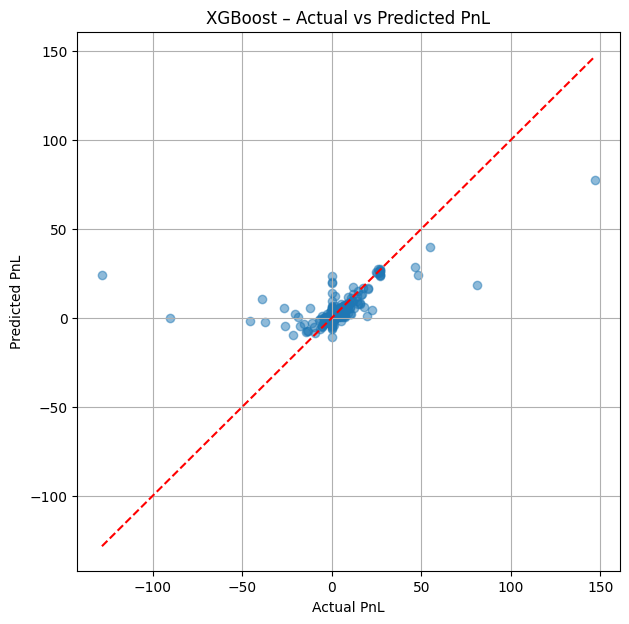

In [42]:
# METRICS & VISUALIZATION

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predictions
xgb_preds = xgb_model.predict(X_test)

# Metrics
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("XGBoost MAE :", mean_absolute_error(y_test, xgb_preds))

# Visualization
plt.figure(figsize=(7,7))
plt.scatter(y_test, xgb_preds, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual PnL")
plt.ylabel("Predicted PnL")
plt.title("XGBoost – Actual vs Predicted PnL")
plt.grid(True)
plt.show()

In [43]:
lstm_preds = lstm.predict(X_lstm[-len(X_test):])

print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, lstm_preds)))
print("LSTM MAE :", mean_absolute_error(y_test, lstm_preds))


1651/1651 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
LSTM RMSE: 1.3131626990478924
LSTM MAE : 0.13963933998980588


In [45]:
import numpy as np

# XGBoost predictions
xgb_preds = xgb_model.predict(X_test)

# LSTM predictions (reshape safely)
X_lstm_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
lstm_preds = lstm.predict(X_lstm_test).flatten()

1651/1651 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [46]:
comparison_df = pd.DataFrame({
    'Actual PnL': y_test.values,
    'XGBoost Predicted PnL': xgb_preds,
    'LSTM Predicted PnL': lstm_preds
}).reset_index(drop=True)

comparison_df.head()

,Actual PnL,XGBoost Predicted PnL,LSTM Predicted PnL
0,-0.015577,0.191374,0.058405
1,-0.050142,-0.009832,0.006080
2,0.062441,0.041190,0.006080
3,-0.053036,-0.028110,0.006080
4,-0.053036,-0.062470,0.004601


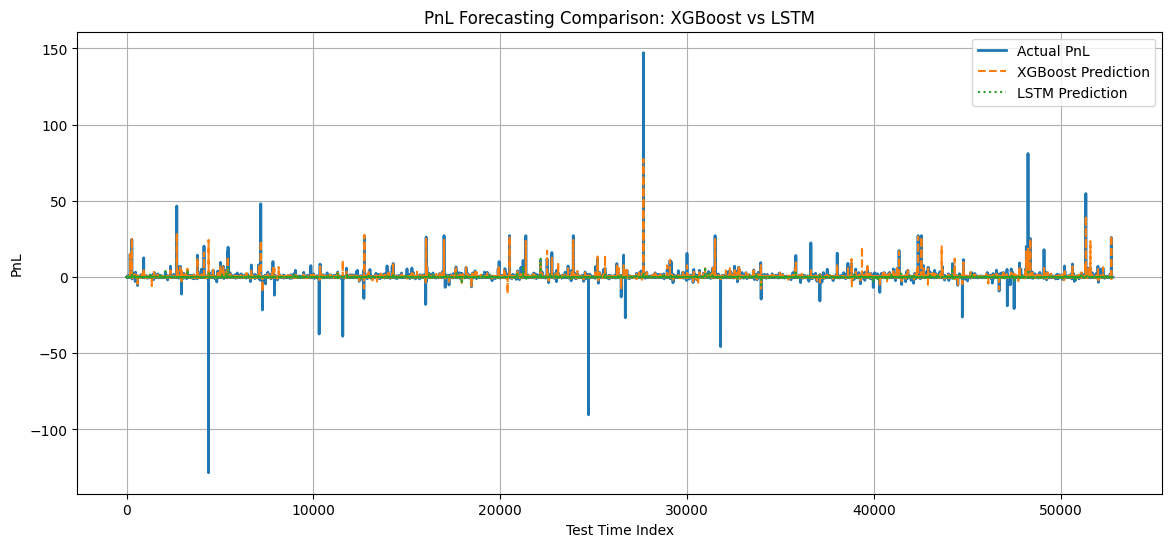

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(comparison_df['Actual PnL'], label='Actual PnL', linewidth=2)
plt.plot(comparison_df['XGBoost Predicted PnL'], label='XGBoost Prediction', linestyle='--')
plt.plot(comparison_df['LSTM Predicted PnL'], label='LSTM Prediction', linestyle=':')

plt.title("PnL Forecasting Comparison: XGBoost vs LSTM")
plt.xlabel("Test Time Index")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.show()


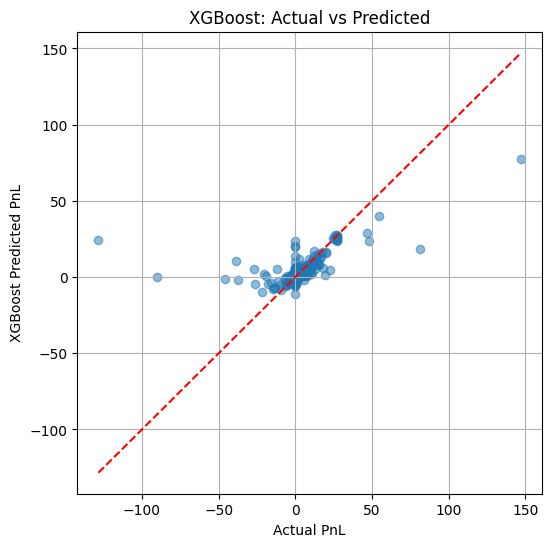

In [48]:
plt.figure(figsize=(6,6))
plt.scatter(comparison_df['Actual PnL'],
            comparison_df['XGBoost Predicted PnL'],
            alpha=0.5)

plt.plot(
    [comparison_df['Actual PnL'].min(), comparison_df['Actual PnL'].max()],
    [comparison_df['Actual PnL'].min(), comparison_df['Actual PnL'].max()],
    'r--'
)

plt.xlabel("Actual PnL")
plt.ylabel("XGBoost Predicted PnL")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)
plt.show()

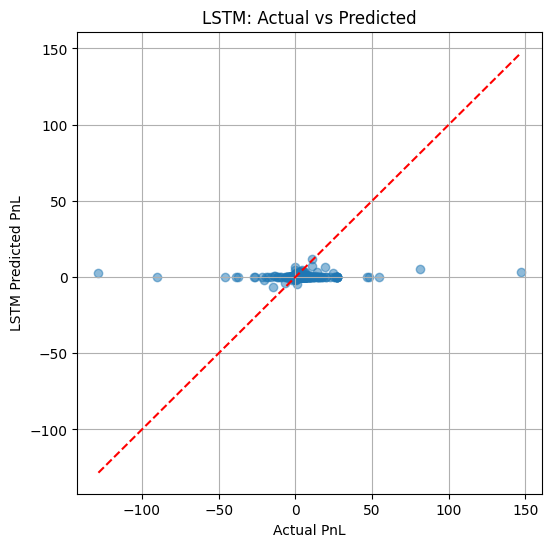

In [49]:
plt.figure(figsize=(6,6))
plt.scatter(comparison_df['Actual PnL'],
            comparison_df['LSTM Predicted PnL'],
            alpha=0.5)

plt.plot(
    [comparison_df['Actual PnL'].min(), comparison_df['Actual PnL'].max()],
    [comparison_df['Actual PnL'].min(), comparison_df['Actual PnL'].max()],
    'r--'
)

plt.xlabel("Actual PnL")
plt.ylabel("LSTM Predicted PnL")
plt.title("LSTM: Actual vs Predicted")
plt.grid(True)
plt.show()

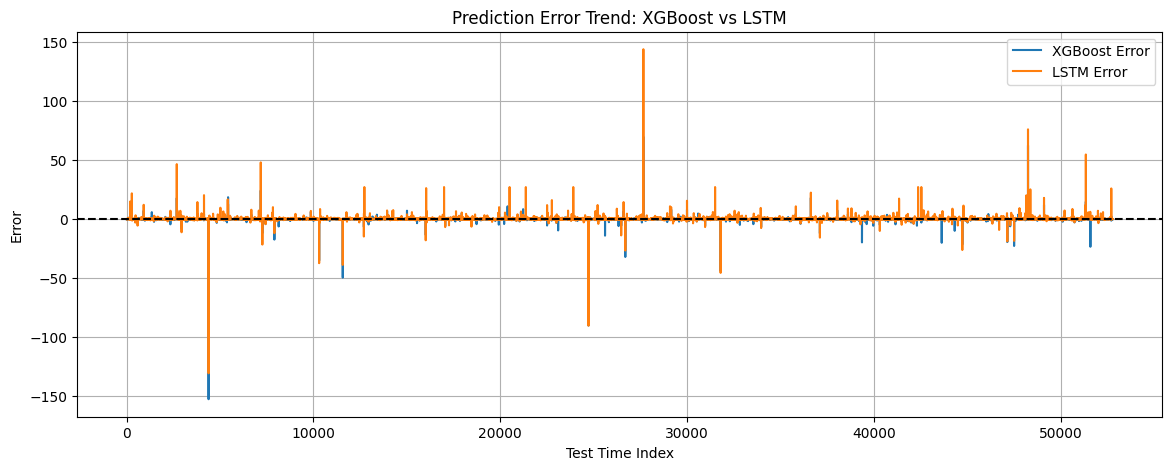

In [50]:
comparison_df['XGB Error'] = comparison_df['Actual PnL'] - comparison_df['XGBoost Predicted PnL']
comparison_df['LSTM Error'] = comparison_df['Actual PnL'] - comparison_df['LSTM Predicted PnL']

plt.figure(figsize=(14,5))
plt.plot(comparison_df['XGB Error'], label='XGBoost Error')
plt.plot(comparison_df['LSTM Error'], label='LSTM Error')

plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Error Trend: XGBoost vs LSTM")
plt.xlabel("Test Time Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, xgb_preds)),
        np.sqrt(mean_squared_error(y_test, lstm_preds))
    ],
    'MAE': [
        mean_absolute_error(y_test, xgb_preds),
        mean_absolute_error(y_test, lstm_preds)
    ]
})

metrics_df


,Model,RMSE,MAE
0,XGBoost,1.030438,0.068304
1,LSTM,1.289156,0.123140


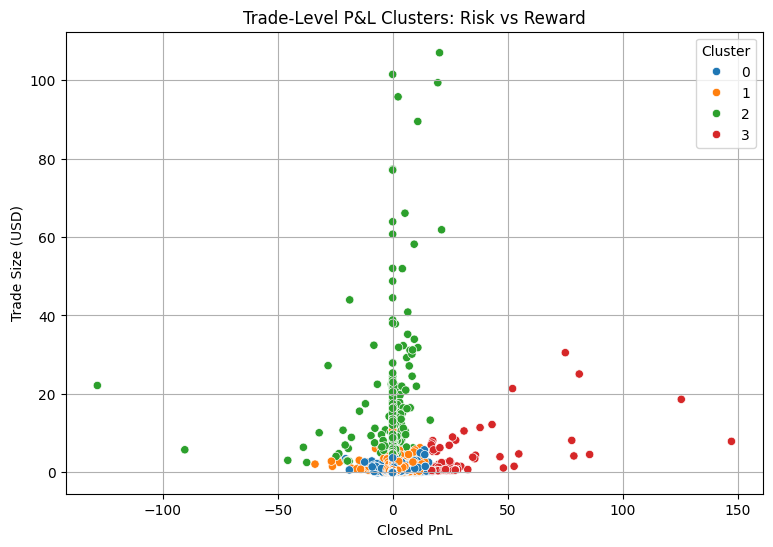

/tmp/ipykernel_55/1344802615.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


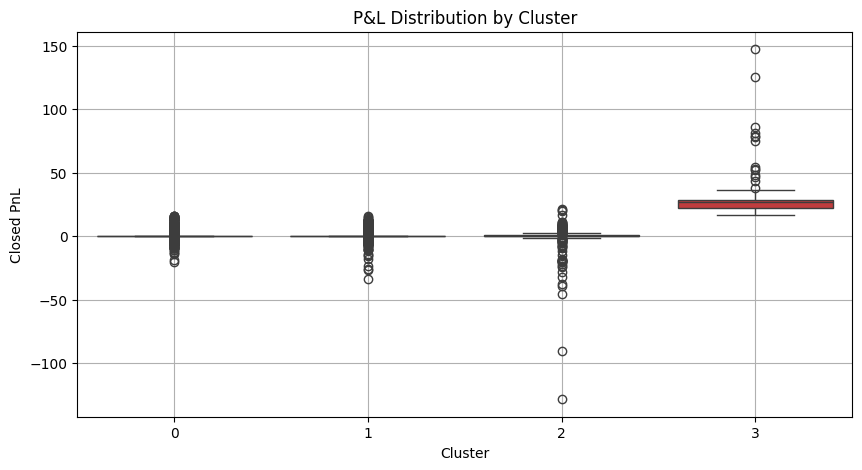

P&L CLUSTER SUMMARY:
             avg_pnl  median_pnl  pnl_volatility  avg_trade_size  avg_fee  \
pnl_cluster                                                                 
0             -0.007      -0.053           0.465          -0.040   -0.033   
1             -0.016      -0.053           0.435          -0.035   -0.043   
2             -0.230      -0.053           7.689          10.801   11.219   
3             32.546      27.145          22.400           3.535    2.834   

             trade_count  
pnl_cluster               
0                  90847  
1                 119594  
2                    701  
3                     82  


/tmp/ipykernel_55/1344802615.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


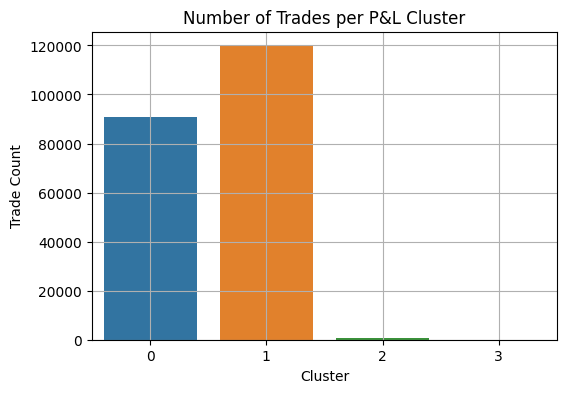

In [64]:
# ============================================================
# TRADE-LEVEL P&L CLUSTERING (UNSUPERVISED) — FULL BLOCK
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ------------------------------------------------------------
# 1. SELECT P&L-CENTRIC FEATURES
# ------------------------------------------------------------
# Assumes df_model already exists from preprocessing

pnl_cluster_df = df_model[[
    'Closed PnL',
    'Size USD',
    'Fee',
    'hour',
    'day_of_week'
]].copy()

# Risk magnitude feature
pnl_cluster_df['abs_pnl'] = np.abs(pnl_cluster_df['Closed PnL'])

# Handle missing values safely
pnl_cluster_df = pnl_cluster_df.fillna(0)

# ------------------------------------------------------------
# 2. SCALE FEATURES (CRITICAL FOR KMEANS)
# ------------------------------------------------------------

scaler = StandardScaler()
X_cluster = scaler.fit_transform(pnl_cluster_df)

# ------------------------------------------------------------
# 3. APPLY KMEANS CLUSTERING
# ------------------------------------------------------------

kmeans = KMeans(
    n_clusters=4,      # can be tuned (3–6 typical)
    random_state=42,
    n_init=10
)

pnl_cluster_df['pnl_cluster'] = kmeans.fit_predict(X_cluster)

# ------------------------------------------------------------
# 4. CLUSTER VISUALIZATION — RISK VS REWARD
# ------------------------------------------------------------

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=pnl_cluster_df,
    x='Closed PnL',
    y='Size USD',
    hue='pnl_cluster',
    palette='tab10'
)
plt.title("Trade-Level P&L Clusters: Risk vs Reward")
plt.xlabel("Closed PnL")
plt.ylabel("Trade Size (USD)")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# ------------------------------------------------------------
# 5. P&L DISTRIBUTION PER CLUSTER
# ------------------------------------------------------------

plt.figure(figsize=(10,5))
sns.boxplot(
    data=pnl_cluster_df,
    x='pnl_cluster',
    y='Closed PnL',
    palette='tab10'
)
plt.title("P&L Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. CLUSTER SUMMARY TABLE (KEY INTERPRETATION)
# ------------------------------------------------------------

cluster_summary = pnl_cluster_df.groupby('pnl_cluster').agg(
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    pnl_volatility=('Closed PnL', 'std'),
    avg_trade_size=('Size USD', 'mean'),
    avg_fee=('Fee', 'mean'),
    trade_count=('Closed PnL', 'count')
).round(3)

print("P&L CLUSTER SUMMARY:")
print(cluster_summary)

# ------------------------------------------------------------
# 7. OPTIONAL: CLUSTER SIZE DISTRIBUTION
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
sns.countplot(
    x='pnl_cluster',
    data=pnl_cluster_df,
    palette='tab10'
)
plt.title("Number of Trades per P&L Cluster")
plt.xlabel("Cluster")
plt.ylabel("Trade Count")
plt.grid(True)
plt.show()

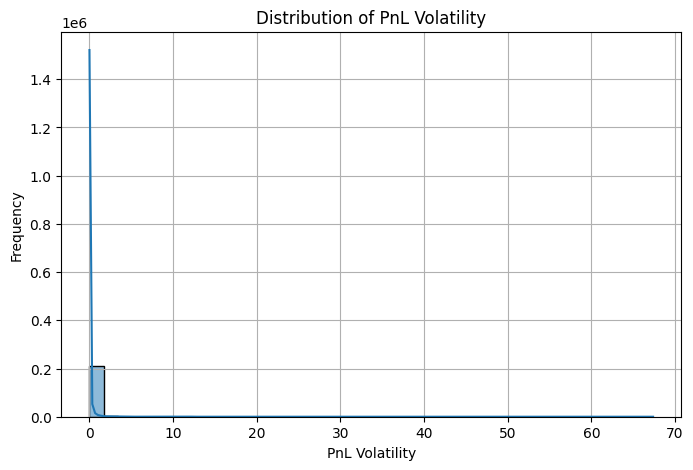

Volatility RMSE: 0.7798224063397926
Volatility MAE : 0.12833341997281958


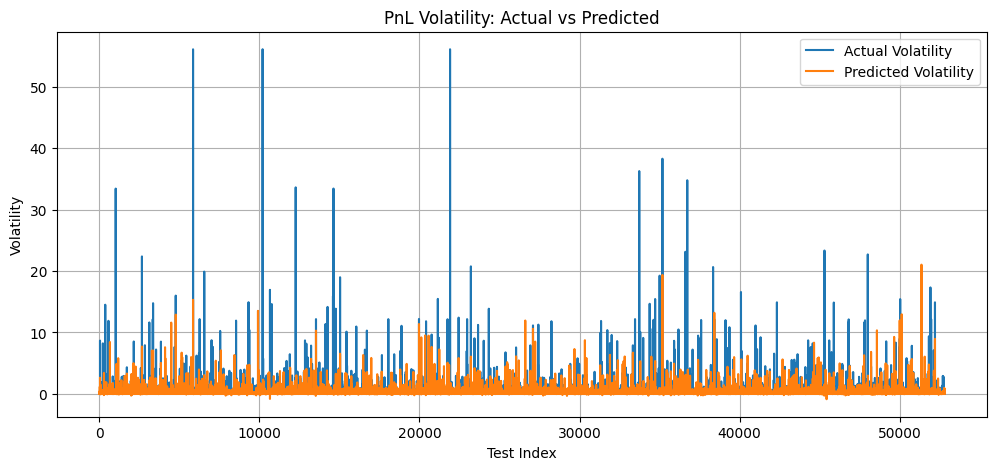

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [65]:
# ============================================================
# BEHAVIORAL PnL VOLATILITY + CLUSTERING + SHAP ANALYSIS
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------------------------------------
# 1. BEHAVIORAL FEATURE ENGINEERING
# ------------------------------------------------------------

df_behavior = df_model.copy()

# Trade-level behavioral signals
df_behavior['abs_pnl'] = np.abs(df_behavior['Closed PnL'])
df_behavior['pnl_direction'] = np.sign(df_behavior['Closed PnL'])
df_behavior['fee_ratio'] = df_behavior['Fee'] / (df_behavior['Size USD'] + 1e-6)

# ------------------------------------------------------------
# 2. PnL VOLATILITY ENGINEERING (BEHAVIORAL)
# ------------------------------------------------------------

df_behavior = df_behavior.sort_values(['Account', 'hour'])

df_behavior['pnl_volatility'] = (
    df_behavior
    .groupby('Account')['Closed PnL']
    .rolling(window=5, min_periods=3)
    .std()
    .reset_index(level=0, drop=True)
)

df_behavior['pnl_volatility'] = df_behavior['pnl_volatility'].fillna(0)

# ------------------------------------------------------------
# 3. VOLATILITY DISTRIBUTION (PROFESSIONAL VISUALS)
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
sns.histplot(df_behavior['pnl_volatility'], bins=40, kde=True)
plt.title("Distribution of PnL Volatility")
plt.xlabel("PnL Volatility")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 4. VOLATILITY PREDICTION (XGBOOST REGRESSION)
# ------------------------------------------------------------

vol_features = [
    'Size USD',
    'Fee',
    'hour',
    'day_of_week',
    'abs_pnl',
    'fee_ratio'
]

X_vol = df_behavior[vol_features]
y_vol = df_behavior['pnl_volatility']

X_train, X_test, y_train, y_test = train_test_split(
    X_vol,
    y_vol,
    test_size=0.25,
    random_state=42
)

xgb_vol = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_vol.fit(X_train, y_train)
vol_preds = xgb_vol.predict(X_test)

print("Volatility RMSE:", np.sqrt(mean_squared_error(y_test, vol_preds)))
print("Volatility MAE :", mean_absolute_error(y_test, vol_preds))

# ------------------------------------------------------------
# 5. VOLATILITY TREND VISUALIZATION
# ------------------------------------------------------------

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual Volatility')
plt.plot(vol_preds, label='Predicted Volatility')
plt.title("PnL Volatility: Actual vs Predicted")
plt.xlabel("Test Index")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. SHAP EXPLAINABILITY (XAI)
# ------------------------------------------------------------

explainer = shap.Explainer(xgb_vol)
shap_values = explainer(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test)

# Feature impact magnitude
shap.summary_plot(shap_values, X_test, plot_type="bar")

# ------------------------------------------------------------
# 7. TRADER-LEVEL BEHAVIORAL AGGREGATION
# ------------------------------------------------------------

trader_behavior = df_behavior.groupby('Account').agg(
    avg_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_trade_size=('Size USD', 'mean'),
    fee_intensity=('fee_ratio', 'mean'),
    trade_count=('Closed PnL', 'count')
).fillna(0)

# ------------------------------------------------------------
# 8. TRADER CLUSTERING (BEHAVIORAL ARCHETYPES)
# ------------------------------------------------------------

scaler = StandardScaler()
X_cluster = scaler.fit_transform(trader_behavior)

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

trader_behavior['cluster'] = kmeans.fit_predict(X_cluster)

# ------------------------------------------------------------
# 9. CLUSTER VISUALIZATION (PAIRWISE)
# ------------------------------------------------------------

sns.pairplot(
    trader_behavior.reset_index(),
    hue='cluster',
    vars=['avg_pnl', 'pnl_volatility', 'trade_count', 'win_rate'],
    palette='tab10'
)
plt.show()

# ------------------------------------------------------------
# 10. CLUSTER SUMMARY TABLE (KEY INSIGHT)
# ------------------------------------------------------------

cluster_summary = trader_behavior.groupby('cluster').agg(
    avg_pnl=('avg_pnl', 'mean'),
    avg_volatility=('pnl_volatility', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    traders=('avg_pnl', 'count')
).round(3)

print("BEHAVIORAL CLUSTER SUMMARY")
print(cluster_summary)

# ------------------------------------------------------------
# 11. CLUSTER DISTRIBUTION VISUAL
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
sns.countplot(x='cluster', data=trader_behavior, palette='tab10')
plt.title("Trader Count per Behavioral Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Traders")
plt.grid(True)
plt.show()


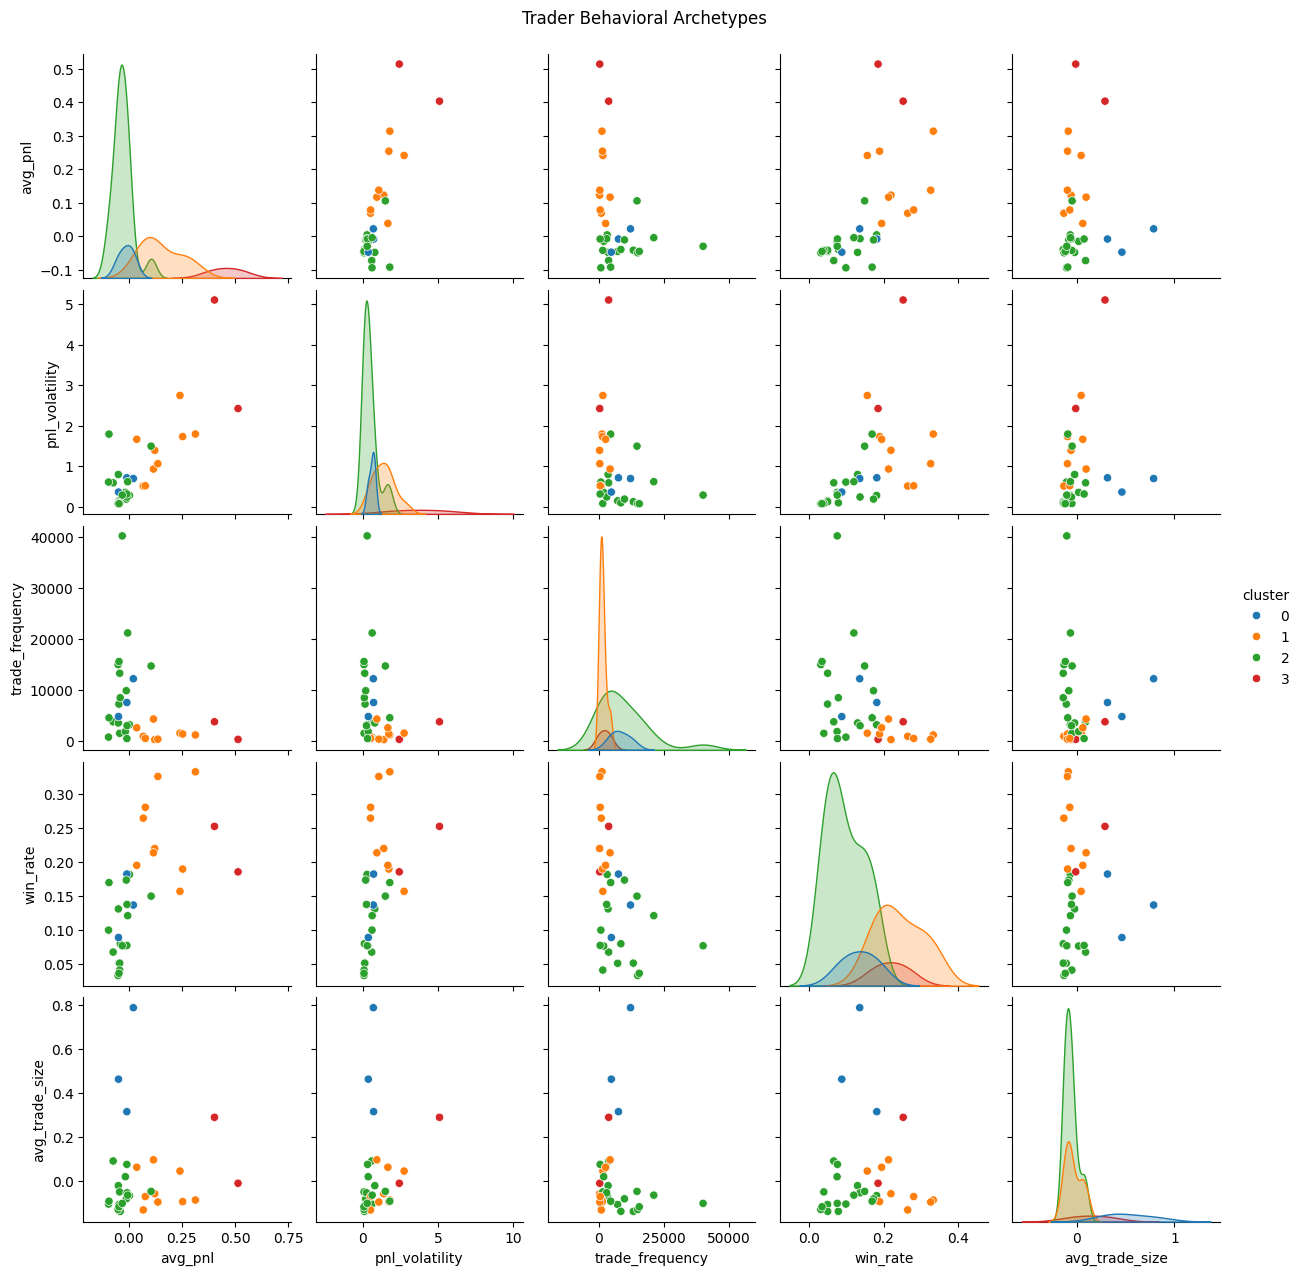

/tmp/ipykernel_55/2055550382.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


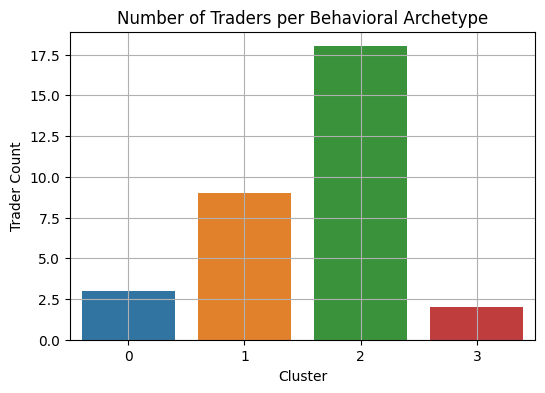

TRADER BEHAVIORAL ARCHETYPE SUMMARY
         avg_pnl  avg_volatility  avg_win_rate  avg_trade_size  \
cluster                                                          
0         -0.012           0.590         0.136           0.520   
1          0.152           1.372         0.242          -0.039   
2         -0.030           0.453         0.097          -0.065   
3          0.458           3.765         0.219           0.138   

         avg_trade_frequency  traders  
cluster                                
0                   8219.333        3  
1                   1504.556        9  
2                   9379.111       18  
3                   2100.500        2  


In [66]:
# TRADER BEHAVIORAL ARCHETYPE CLUSTERING

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ------------------------------------------------------------
# 1. AGGREGATE TRADER-LEVEL BEHAVIOR
# ------------------------------------------------------------
# Assumes df_model exists and is clean

trader_behavior = df_model.groupby('Account').agg(
    avg_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_trade_size=('Size USD', 'mean'),
    trade_frequency=('Closed PnL', 'count'),
    fee_intensity=('Fee', lambda x: x.sum()),
).fillna(0)

# Normalize fee by activity
trader_behavior['fee_per_trade'] = (
    trader_behavior['fee_intensity'] /
    (trader_behavior['trade_frequency'] + 1e-6)
)

trader_behavior = trader_behavior.drop(columns=['fee_intensity'])

# ------------------------------------------------------------
# 2. SCALE FEATURES (CRITICAL)
# ------------------------------------------------------------

scaler = StandardScaler()
X_cluster = scaler.fit_transform(trader_behavior)

# ------------------------------------------------------------
# 3. KMEANS CLUSTERING (ARCHETYPES)
# ------------------------------------------------------------

kmeans = KMeans(
    n_clusters=4,     # archetypes (can be justified later)
    random_state=42,
    n_init=10
)

trader_behavior['cluster'] = kmeans.fit_predict(X_cluster)

# ------------------------------------------------------------
# 4. CLUSTER VISUALIZATION (PAIRWISE)
# ------------------------------------------------------------

sns.pairplot(
    trader_behavior.reset_index(),
    hue='cluster',
    vars=[
        'avg_pnl',
        'pnl_volatility',
        'trade_frequency',
        'win_rate',
        'avg_trade_size'
    ],
    palette='tab10'
)
plt.suptitle("Trader Behavioral Archetypes", y=1.02)
plt.show()

# ------------------------------------------------------------
# 5. CLUSTER DISTRIBUTION
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
sns.countplot(
    x='cluster',
    data=trader_behavior,
    palette='tab10'
)
plt.title("Number of Traders per Behavioral Archetype")
plt.xlabel("Cluster")
plt.ylabel("Trader Count")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 6. CLUSTER SUMMARY TABLE (KEY OUTPUT)
# ------------------------------------------------------------

cluster_summary = trader_behavior.groupby('cluster').agg(
    avg_pnl=('avg_pnl', 'mean'),
    avg_volatility=('pnl_volatility', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_trade_frequency=('trade_frequency', 'mean'),
    traders=('avg_pnl', 'count')
).round(3)

print("TRADER BEHAVIORAL ARCHETYPE SUMMARY")
print(cluster_summary)

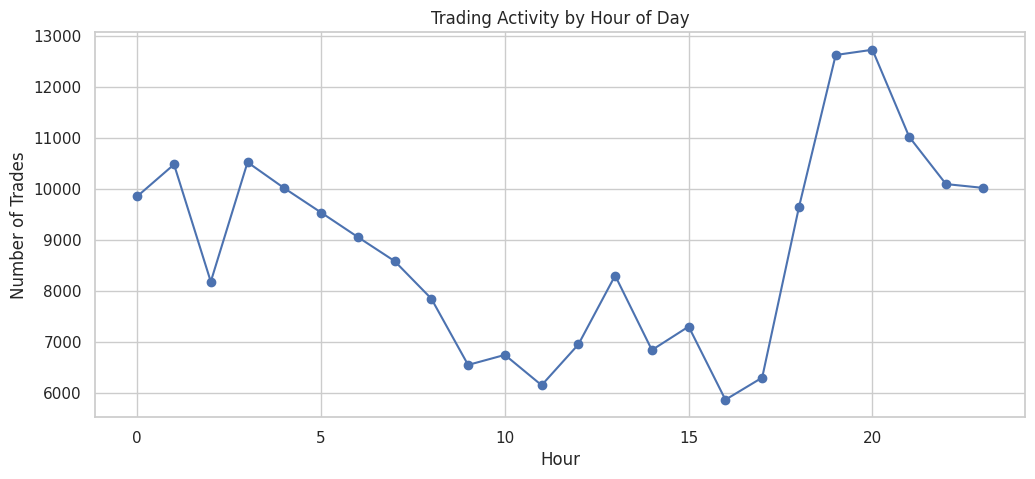

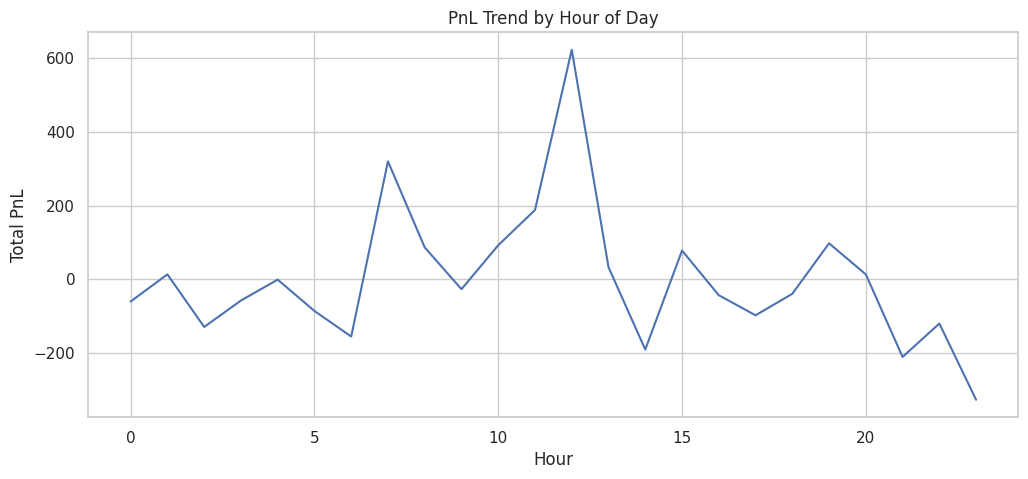

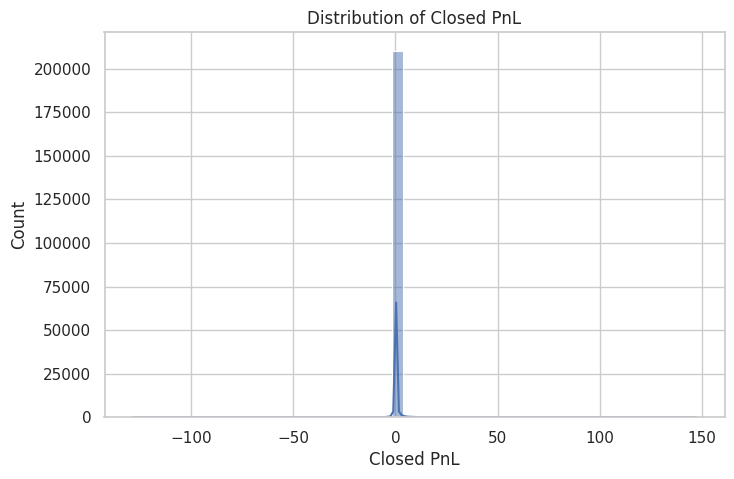

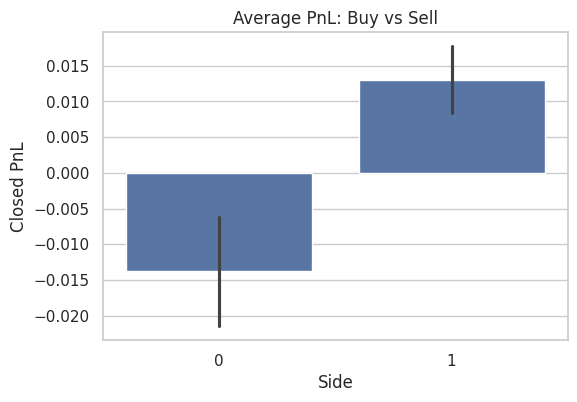

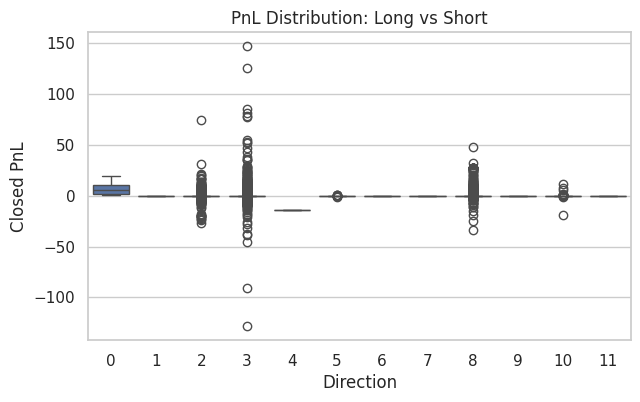

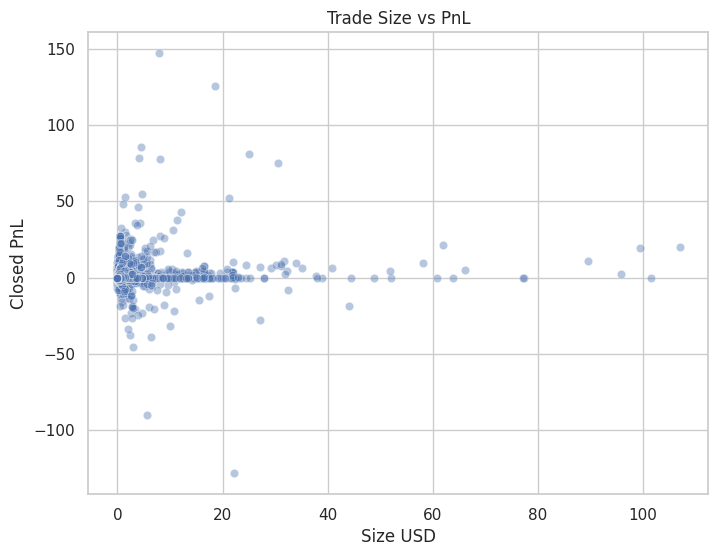

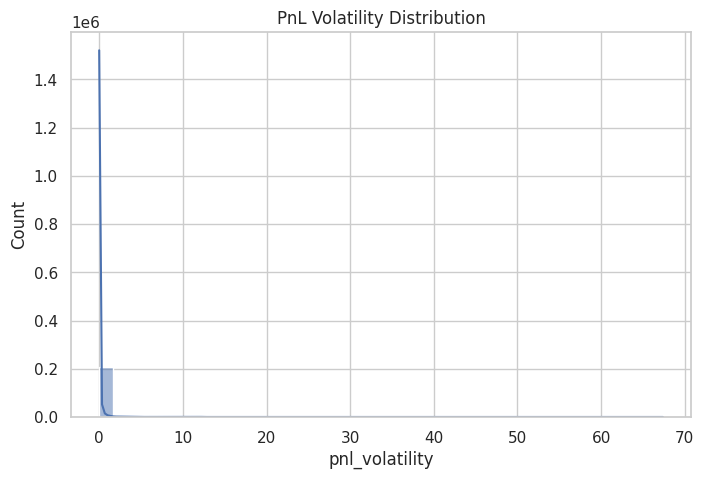

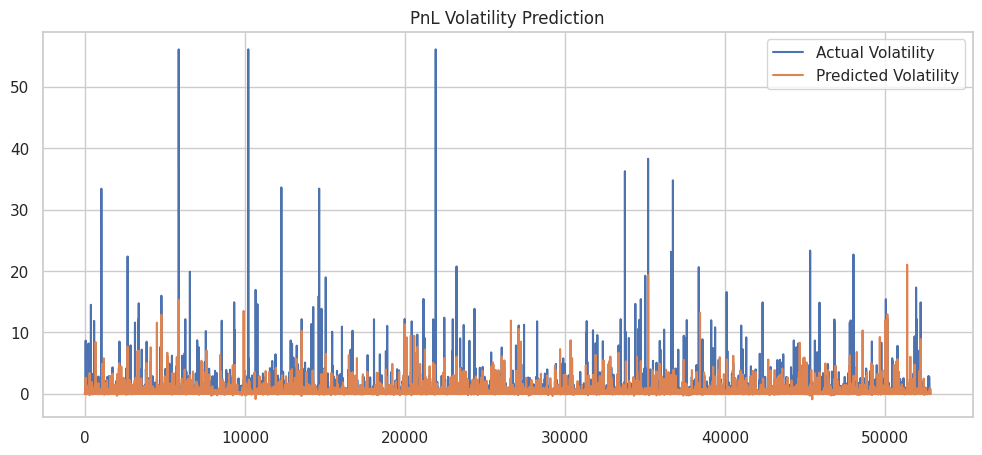

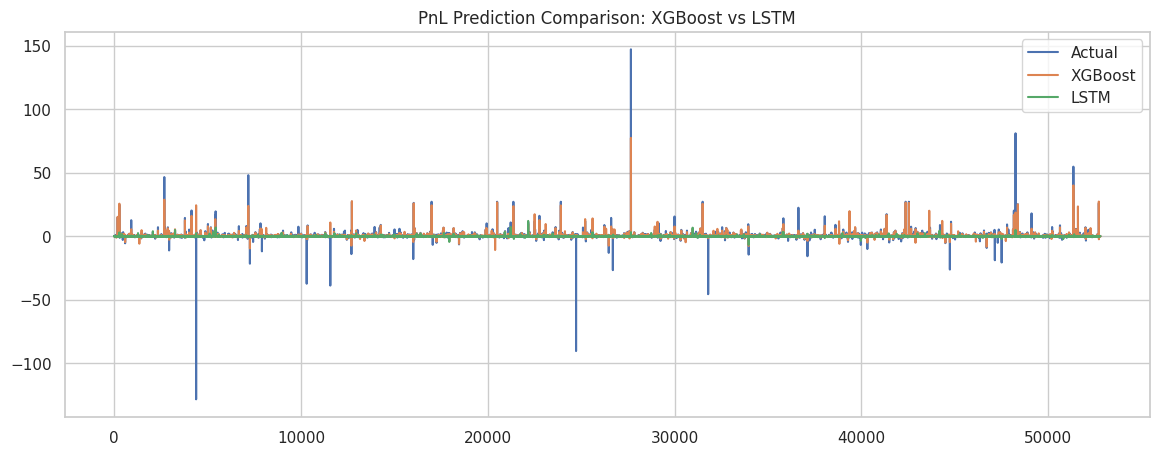

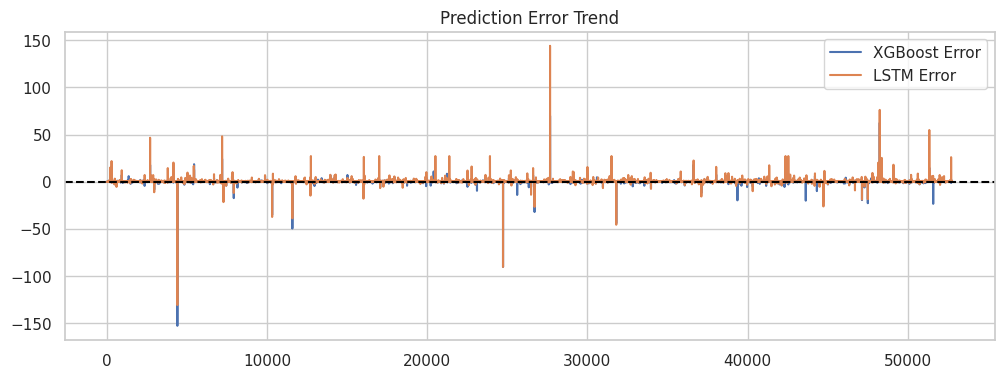

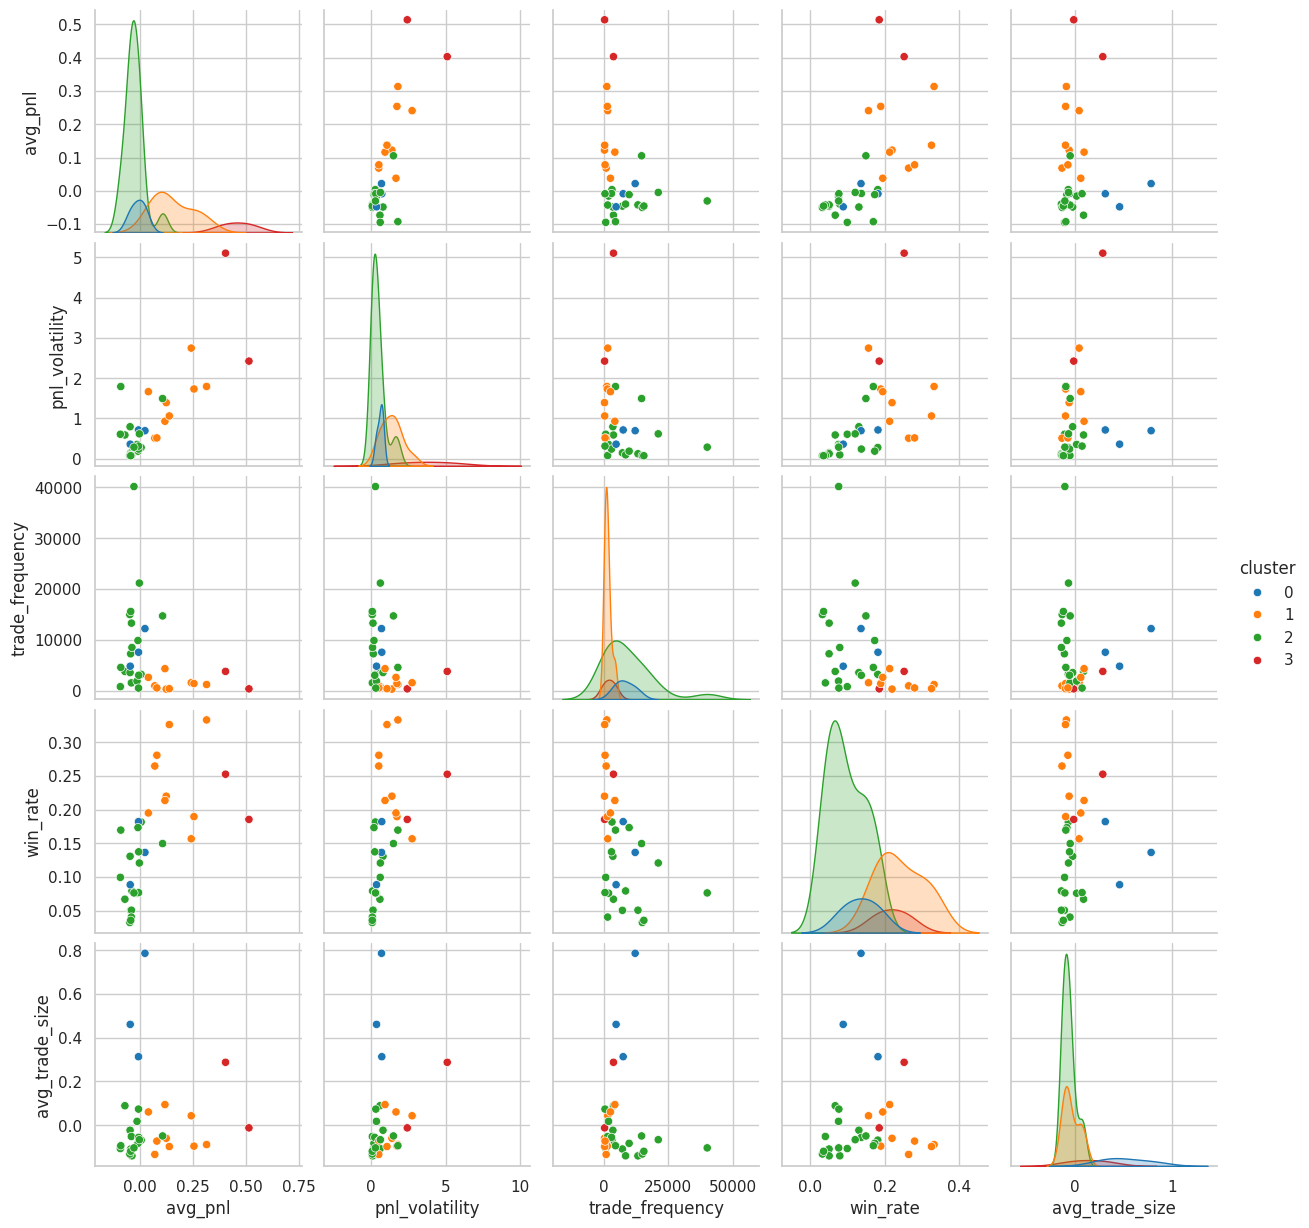

/tmp/ipykernel_55/4123786288.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=trader_behavior, palette='tab10')


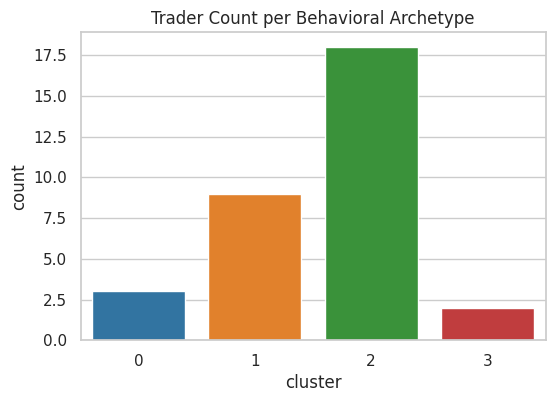

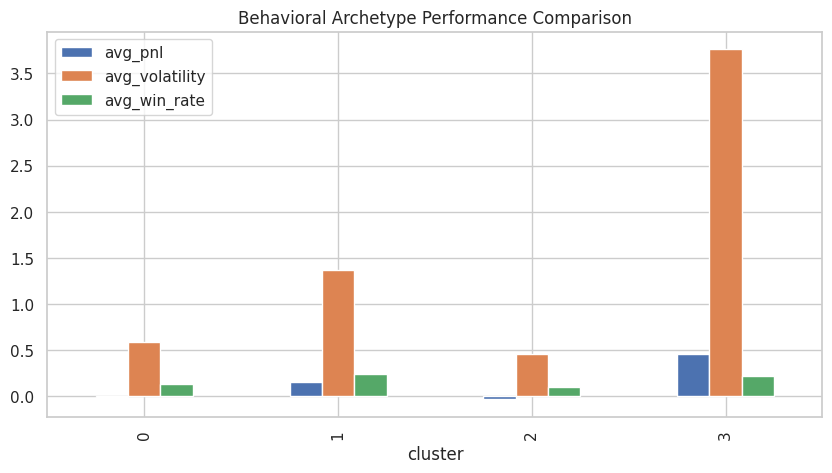

In [68]:
# ============================================================
# FULL PROJECT VISUALIZATION + SHAP SUITE (15 GRAPHS)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. Trading Activity by Hour (Line)
# ------------------------------------------------------------
plt.figure(figsize=(12,5))
df_model.groupby('hour')['Closed PnL'].count().plot(marker='o')
plt.title("Trading Activity by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trades")
plt.show()

# ------------------------------------------------------------
# 2. PnL Trend by Hour (Line)
# ------------------------------------------------------------
plt.figure(figsize=(12,5))
df_model.groupby('hour')['Closed PnL'].sum().plot()
plt.title("PnL Trend by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Total PnL")
plt.show()

# ------------------------------------------------------------
# 3. PnL Distribution (Histogram + KDE)
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df_model['Closed PnL'], bins=50, kde=True)
plt.title("Distribution of Closed PnL")
plt.show()

# ------------------------------------------------------------
# 4. Buy vs Sell Performance (Bar)
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.barplot(data=df_model, x='Side', y='Closed PnL', estimator=np.mean)
plt.title("Average PnL: Buy vs Sell")
plt.show()

# ------------------------------------------------------------
# 5. Long vs Short Risk Profile (Boxplot)
# ------------------------------------------------------------
plt.figure(figsize=(7,4))
sns.boxplot(data=df_model, x='Direction', y='Closed PnL')
plt.title("PnL Distribution: Long vs Short")
plt.show()

# ------------------------------------------------------------
# 6. Trade Size vs PnL (Scatter)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_model, x='Size USD', y='Closed PnL', alpha=0.4)
plt.title("Trade Size vs PnL")
plt.show()

# ------------------------------------------------------------
# 7. PnL Volatility Distribution (Histogram)
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df_behavior['pnl_volatility'], bins=40, kde=True)
plt.title("PnL Volatility Distribution")
plt.show()

# ------------------------------------------------------------
# 8. Actual vs Predicted Volatility (Line)
# ------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual Volatility')
plt.plot(vol_preds, label='Predicted Volatility')
plt.title("PnL Volatility Prediction")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 9. XGBoost vs LSTM vs Actual PnL (Trend)
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(comparison_df['Actual PnL'], label='Actual')
plt.plot(comparison_df['XGBoost Predicted PnL'], label='XGBoost')
plt.plot(comparison_df['LSTM Predicted PnL'], label='LSTM')
plt.title("PnL Prediction Comparison: XGBoost vs LSTM")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 10. Prediction Error Trend (Line)
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(comparison_df['XGB Error'], label='XGBoost Error')
plt.plot(comparison_df['LSTM Error'], label='LSTM Error')
plt.axhline(0, linestyle='--', color='black')
plt.title("Prediction Error Trend")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 13. Trader Behavioral Archetypes (Pairplot)
# ------------------------------------------------------------
sns.pairplot(
    trader_behavior.reset_index(),
    hue='cluster',
    vars=['avg_pnl','pnl_volatility','trade_frequency','win_rate','avg_trade_size'],
    palette='tab10'
)
plt.show()

# ------------------------------------------------------------
# 14. Trader Count per Archetype (Bar)
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='cluster', data=trader_behavior, palette='tab10')
plt.title("Trader Count per Behavioral Archetype")
plt.show()

# ------------------------------------------------------------
# 15. Archetype Performance Comparison (Bar)
# ------------------------------------------------------------
cluster_summary[['avg_pnl','avg_volatility','avg_win_rate']].plot(
    kind='bar',
    figsize=(10,5)
)
plt.title("Behavioral Archetype Performance Comparison")
plt.show()

  0%|          | 0/52806 [00:00<?, ?it/s]

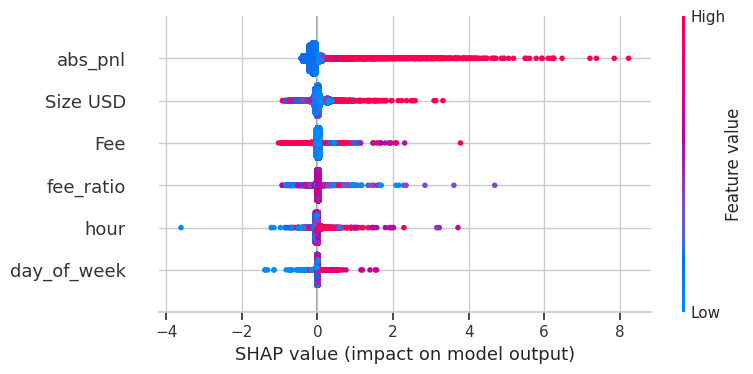

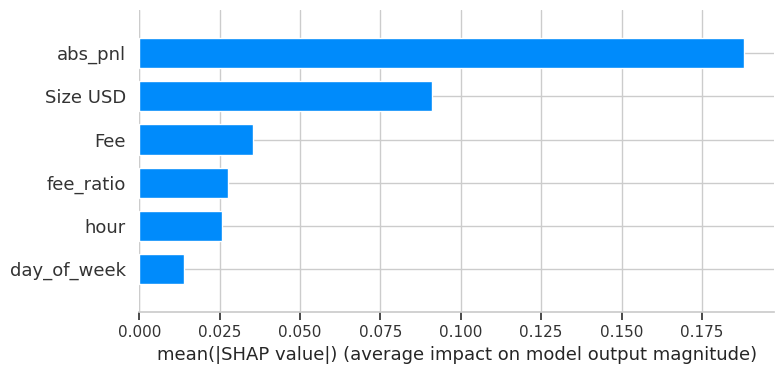

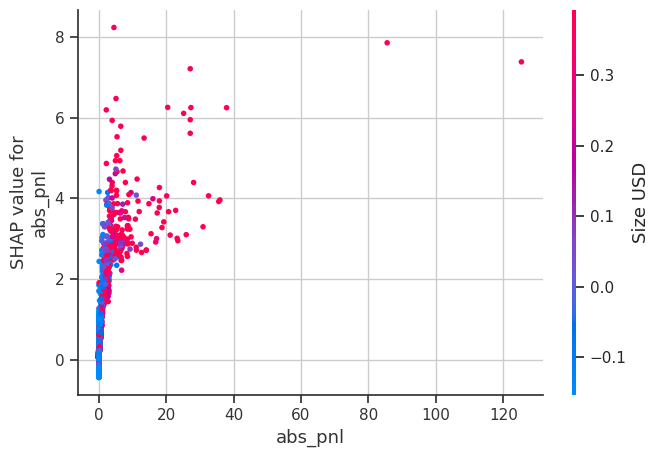

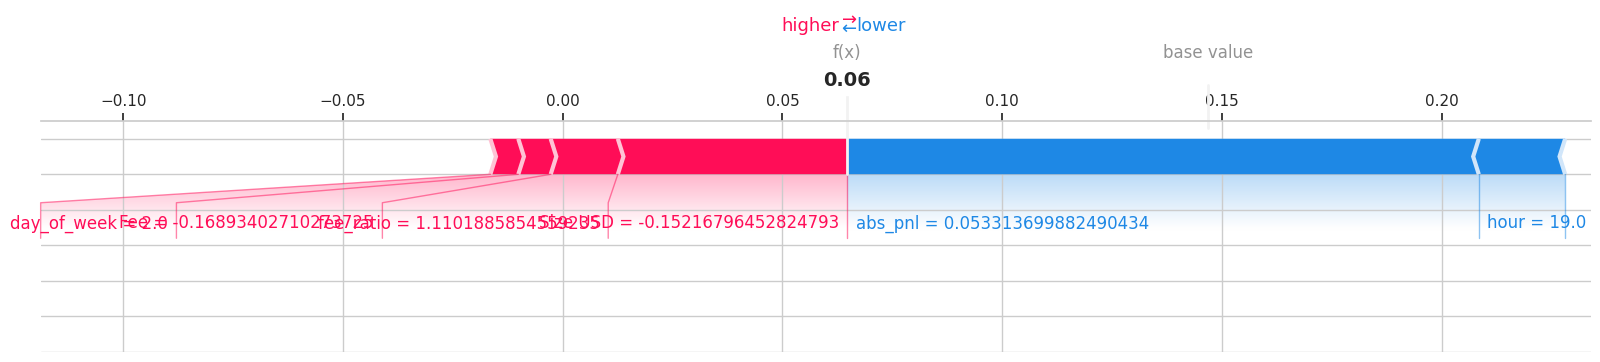

In [75]:
import shap
import numpy as np
import pandas as pd

X_background = shap.sample(X_train, 100)

def model_predict(X):
    return xgb_vol.predict(pd.DataFrame(X, columns=X_test.columns))

explainer = shap.KernelExplainer(
    model_predict,
    X_background
)

shap_values = explainer.shap_values(
    X_test,
    nsamples=100
)

shap.summary_plot(
    shap_values,
    X_test
)

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar"
)

top_feature = (
    pd.Series(np.abs(shap_values).mean(axis=0), index=X_test.columns)
    .sort_values(ascending=False)
    .index[0]
)

shap.dependence_plot(
    top_feature,
    shap_values,
    X_test
)

shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    matplotlib=True
)